In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import shap
shap.initjs()

#### Methodology

I chose to build a binary classifier using LightGBM - gradient boosting framework that uses tree based learning algorithms developed by Microsoft. Based from experience I find that Gradient boosted trees have shown high accuracy. Since I have no idea about what the variables represent in real life, tree based algorithm will make more sense to use since it makes no assumptions on relationships between features.

#### load data and check distribution of values per column

In [2]:
data0 = pd.read_csv('DataChallenge/dataset_train_1.csv', index_col=0)
data0.head(1)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Target
1,K1,128.0,415.0,01dc820b1aa6175cef997a09f88da685,no,yes,25.0,265.1,110.0,45.07,...,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.7,1.0,False.


In [3]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2998 entries, 1 to 2998
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Var1    2774 non-null   object 
 1   Var2    2764 non-null   float64
 2   Var3    2992 non-null   float64
 3   Var4    2767 non-null   object 
 4   Var5    2978 non-null   object 
 5   Var6    2807 non-null   object 
 6   Var7    2724 non-null   float64
 7   Var8    2787 non-null   float64
 8   Var9    2727 non-null   float64
 9   Var10   2915 non-null   float64
 10  Var11   2836 non-null   float64
 11  Var12   2839 non-null   float64
 12  Var13   2830 non-null   float64
 13  Var14   2710 non-null   float64
 14  Var15   2997 non-null   float64
 15  Var16   2872 non-null   float64
 16  Var17   2909 non-null   float64
 17  Var18   2788 non-null   float64
 18  Var19   2958 non-null   float64
 19  Var20   2753 non-null   float64
 20  Target  2948 non-null   object 
dtypes: float64(16), object(5)
memory usag

In [4]:
data0.describe()

,Var2,Var3,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20
count,2764.000000,2992.000000,2724.000000,2787.000000,2727.000000,2915.000000,2836.000000,2839.000000,2830.000000,2710.000000,2997.000000,2872.000000,2909.000000,2788.000000,2958.000000,2753.000000
mean,100.686686,437.115307,8.052863,180.233943,100.059773,30.612631,200.931911,99.892568,17.043742,200.596494,100.001668,9.033955,10.230320,4.488522,2.764047,1.550672
std,39.721081,42.333905,13.644352,54.491987,20.245062,9.288033,50.924026,19.875673,4.341361,50.491350,19.569405,2.281975,2.786336,2.455388,0.750529,1.309511
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,144.500000,87.000000,24.560000,166.475000,87.000000,14.100000,167.100000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.400000,100.000000,30.500000,201.400000,100.000000,17.090000,200.650000,100.000000,9.030000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,19.000000,216.350000,114.000000,36.805000,235.500000,113.000000,19.977500,234.900000,113.000000,10.590000,12.000000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,168.000000,30.910000,395.000000,175.000000,17.770000,20.000000,19.000000,5.400000,9.000000


In [5]:
data0.describe(include=[object])

,Var1,Var4,Var5,Var6,Target
count,2774,2767,2978,2807,2948
unique,50,2767,2,2,2
top,S1,01dc820b1aa6175cef997a09f88da685,no,no,False.
freq,91,1,2685,2027,2514


#### The data is heavily imbalanced with around 5x more negative (`False`) labeled data points

In [6]:
data0.Target.value_counts()

False.    2514
True.      434
Name: Target, dtype: int64

#### Reformat data for Exploratory analysis

   - exclude data points with `Target = NaN`
   - Replace:
       - `True.` -> 1
       - `False.` -> 0
       - `yes` -> 1
       - `no` -> 0
   - fill null entries of categorical variables:
        - `Var1` -> `NN`
        - `Var2` -> `2`
        - `Var3` -> `2`

In [7]:
def reformat_data (df):
    df = df.dropna(subset=['Target']).reset_index(drop=True)
    df['Target'] = df.Target.apply(lambda x: 1 if x == 'True.' else 0).astype('category')
    df['Var1'] = df.Var1.fillna('NN').astype('category')
    bin_map = {'yes': 1, 'no': 0}
    df['Var5'] = df.Var5.apply(lambda x: 2 if pd.isnull(x) else bin_map[x]).astype('category')
    df['Var6'] = df.Var6.apply(lambda x: 2 if pd.isnull(x) else bin_map[x]).astype('category')
    return df

In [8]:
data = reformat_data (data0.copy())
data.head(1)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Target
0,K1,128.0,415.0,01dc820b1aa6175cef997a09f88da685,0,1,25.0,265.1,110.0,45.07,...,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.7,1.0,0


In [9]:
data.Var1.value_counts()

NN    219
S1     89
W3     81
M5     71
W4     70
O1     65
N8     64
V1     64
U1     63
O3     63
A2     62
C3     62
M4     62
I2     61
V2     60
T2     60
I4     60
K1     60
W2     60
M8     59
F1     58
N7     57
N1     56
N5     56
M2     55
R1     55
C2     55
A4     53
M6     52
W1     52
N3     52
K2     52
N6     51
N2     50
M7     49
M1     49
M3     48
D2     48
O2     46
I3     46
G1     46
H1     45
A1     45
N4     43
D1     43
A3     43
P1     42
T1     41
L1     39
I1     36
C1     30
Name: Var1, dtype: int64

In [10]:
data.Var5.value_counts()

0    2638
1     290
2      20
Name: Var5, dtype: int64

In [11]:
data.Var6.value_counts()

0    1996
1     764
2     188
Name: Var6, dtype: int64

#### Check for correlated variables and keep 1 of the pair
- tree-based models have an innate feature of being robust to correlated features, it makes no difference to retain all or keep 1 correlated variables but in real world the number of variables and data could grow and it would save time to train the model when we have lesser features.
    - `Var8` and `Var10` are correlated, keep `Var8`
    - `Var11` and `Var13` are correlated, keep `Var11`
    - `Var14` and `Var16` are correlated, keep `Var14`
    - `Var17` and `Var19` are correlated, keep `Var17`

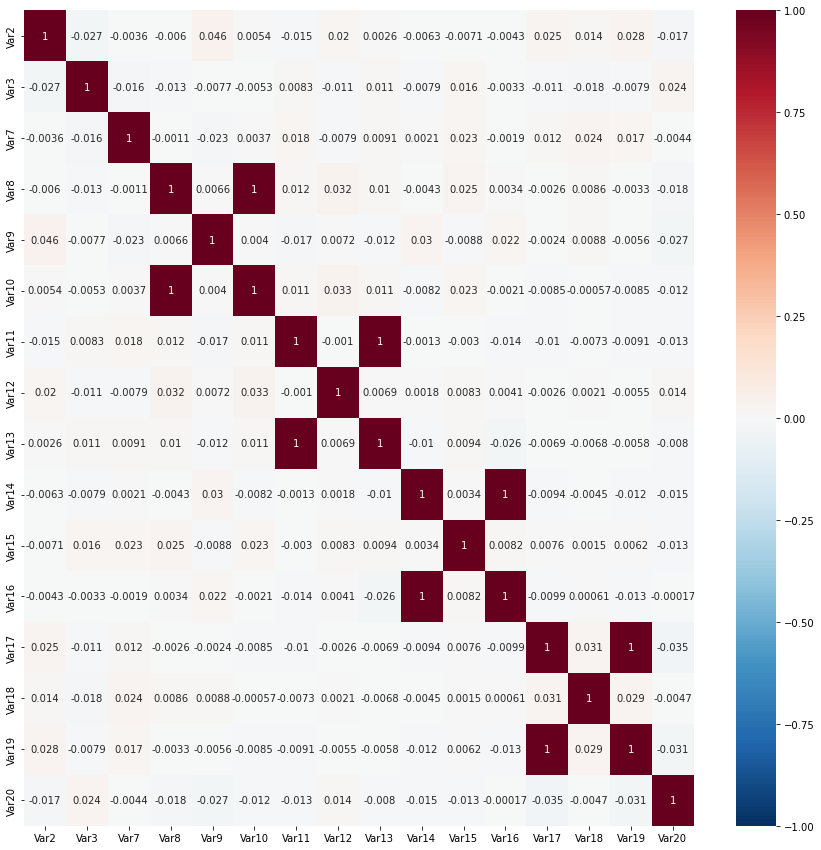

In [12]:
corr = data.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()

In [13]:
categorical_feats = ['Var1', 'Var5', 'Var6']
target_name = 'Target'
features_names = [c for c in data.columns if c not in [target_name, 'Var4', 'Var10','Var13','Var16','Var19']]
numeric_feats = [f for f in features_names if f not in categorical_feats]

#### Check the distribution of values of categorical columns per target
- we can see that there are slight differences of the distribution between positive and negative samples in `Var1`
- the ratio between `Var5 = 1` vs. `0` and `2` values is higher for *positive* samples compared to negative samples
- the ratio between `Var6 = 1` vs. `0` and `2` values is higher for *negative* samples compared to negative samples
- all these categorical values will be considered as input to the model

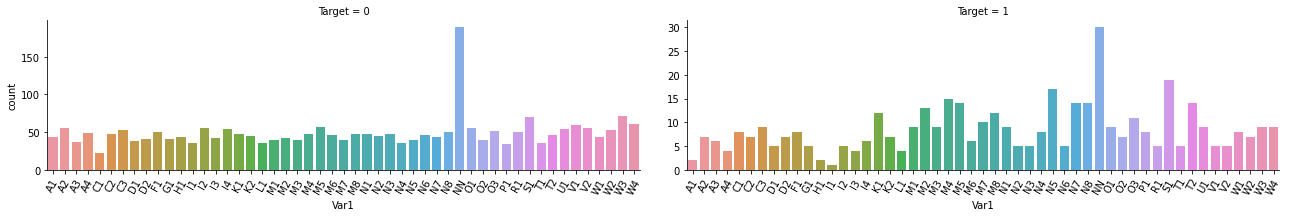

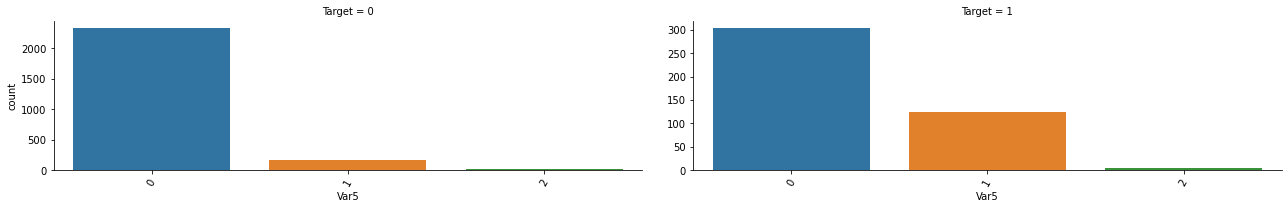

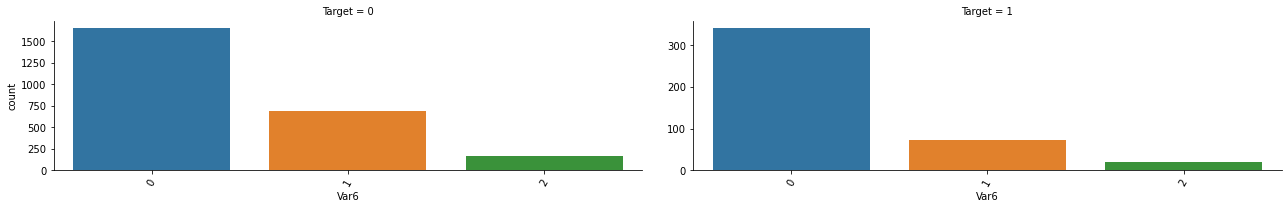

In [14]:
for col in categorical_feats:
    g = sns.catplot(x=col, kind='count', col=target_name, data=data, sharey=False, height=3, aspect=3)
    g.set_xticklabels(rotation=60)

#### Check the distribution of values of quantitaive columns per target
- most of the variables follow similar distibution except for `Var8`, `Var11`, `Var18` and `Var20` 
- variables that show difference in distribution between positive and negative samples will be used as a 'differentiator' by the model
- ideally I would use features shat show obvious differences in the distribution as features to train my model but in this case differences of the distributions per variable is less obvious and at times minimal so I decided to give all these quantitative variables below as input to the model

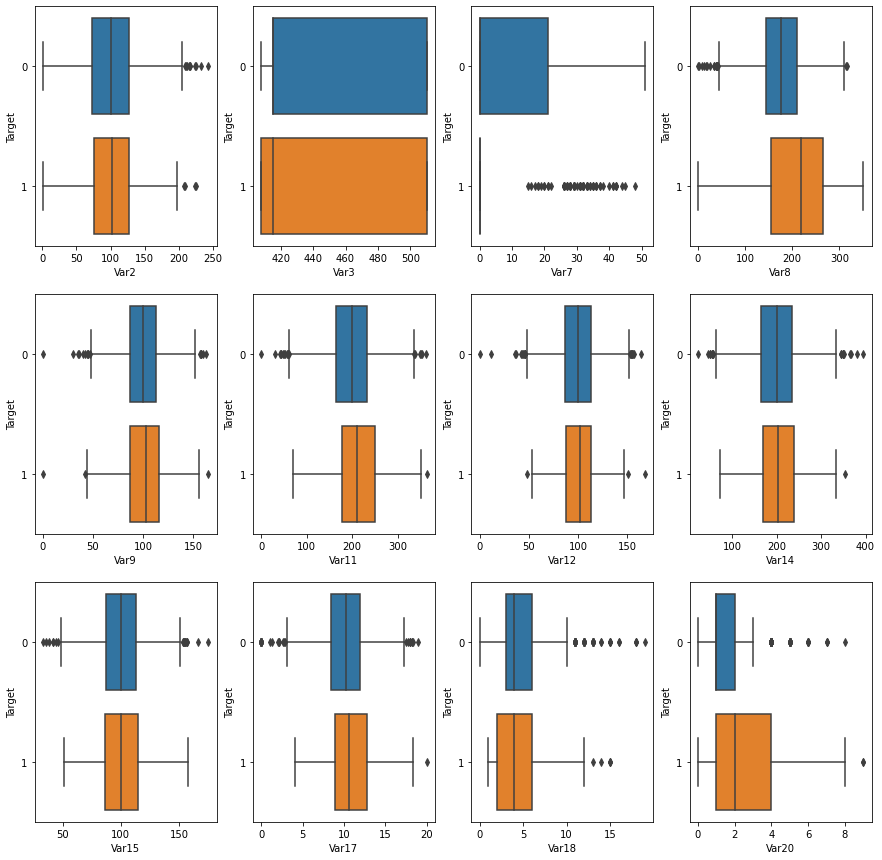

In [15]:
f, axes = plt.subplots(3, 4, figsize=(15,15))
for col, ax in zip(numeric_feats, axes.flatten()):
    sns.boxplot(y=data[target_name], x = col, data=data, ax=ax)
plt.show()

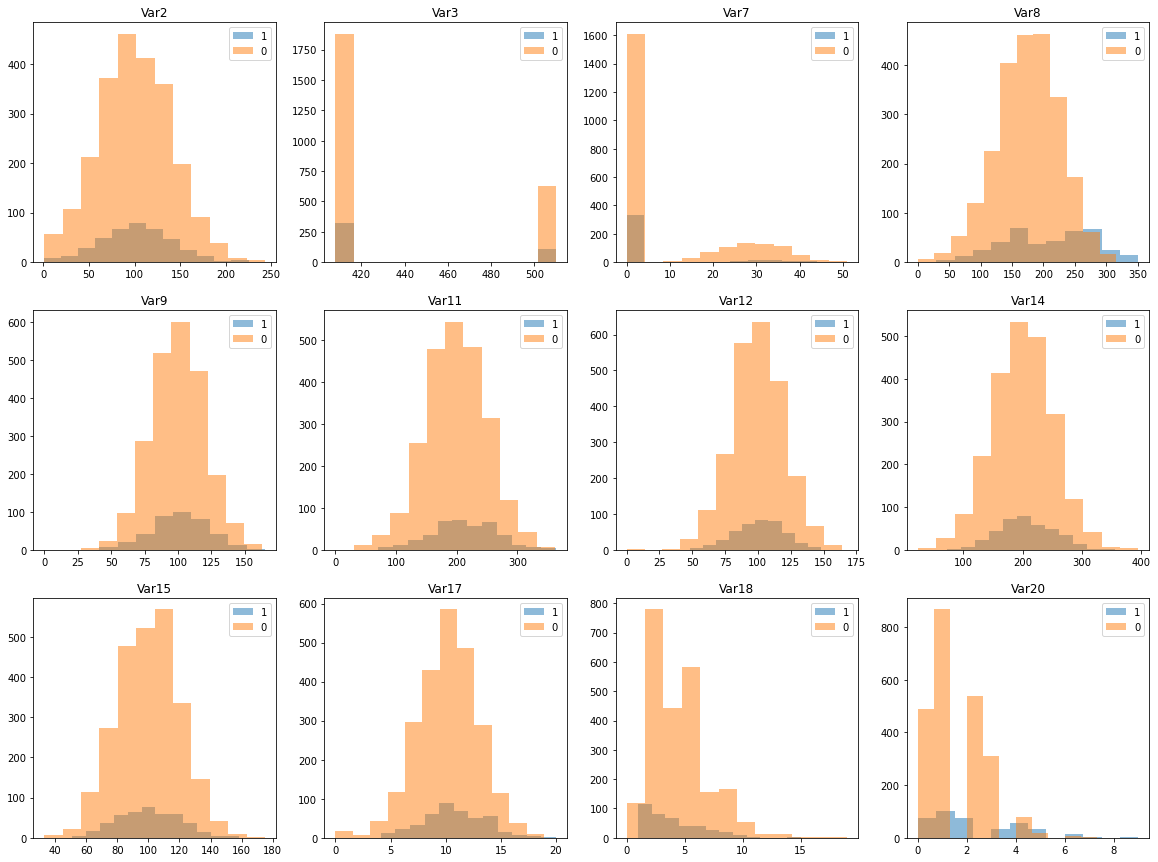

In [16]:
f, axes = plt.subplots(3, 4, figsize=(20,15))
for col, ax in zip(numeric_feats, axes.flatten()):
    data[data.Target == 1][col].hist(ax=ax, grid=False, bins=12, alpha=0.5, label=1)
    data[data.Target == 0][col].hist(ax=ax, grid=False, bins=12, alpha=0.5, label=0)
    ax.set_title(col)
    ax.legend()
plt.show()

#### Reformat original data, suitable as input to the model
- exclude data points with `Target = NaN`
- Replace:
   - `True.` -> 1
   - `False.` -> 0

In [17]:
def reformat_data (df):
    df = df.dropna(subset=['Target']).reset_index(drop=True)
    df['Target'] = df.Target.apply(lambda x: 1 if x == 'True.' else 0)
    return df

data = reformat_data(data0.copy())

#### Prepare data pipeline for training and applying model
- Split `dataset_train_1.csv` to training and validation sets, take approximately the same percentage of samples of each target class for each categories in `Var1`
- `Var1`:
    - `NaN` -> `NN` -> trasform column into 51-D vectors which corresponds to 50 categories + 1 `null`
- `Var5 and Var6`:
    - `NaN` -> `null` -> trasform each columns into 3-D vectors which corresponds to `yes`, `no` and `null`

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data[features_names], 
                                                    data[target_name],
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=data['Var1'].fillna('NN')
                                                   )

cat_pipeline = Pipeline([
    ('fill_cat', SimpleImputer(strategy='constant', fill_value='NN')),
    ('cat', OneHotEncoder()),
])

bin_pipeline = Pipeline([
    ('fill_bin', SimpleImputer(strategy='constant', fill_value='null')),
    ('bin_encode', OneHotEncoder()),
])

data_pipeline = ColumnTransformer([
    ('fill_cat', cat_pipeline, ['Var1']),
    ('bin_cat', bin_pipeline, ['Var5', 'Var6']),
    ('numerical', SimpleImputer(strategy='constant', fill_value=0), numeric_feats),
])

X_train = data_pipeline.fit_transform(X_train)
X_test = data_pipeline.transform(X_test)
cat_feats_end = X_train.shape[1]-len(numeric_feats)

#### Optimal parameters found using [hyperopt](http://hyperopt.github.io/hyperopt/) (Did hyperparameter tuning outside of this notebook to get the numbers below)

In [19]:
lgb_opt = \
{'learning_rate': 0.1923425202039256,
 'max_bin': 73,
 'max_depth': 10,
 'reg_alpha': 0.6088971113062082,
 'reg_lambda': 0.1024901117302882,
 'subsample': 0.9552827059520883}

#### Train binary classifier using LightGBM
- used AUC metric to evaluate the performance of the model since we have unbalanced binary target
- used LightGBM built in parameter for training unbalanced data
- used early stopping feature which stops at the number of trees when evaluation score has not improved over the specified number of iterations; this will prevent the model from overfitting
- Speficify categorical variables as LightGBM treats quantitative and categorical variables differently when splitting the data

In [20]:
X_train_processed = lgb.Dataset(X_train,
                                label=y_train,
                                categorical_feature=list(range(cat_feats_end))
                               )
X_test_processed = lgb.Dataset(X_test,
                               label=y_test,
                               categorical_feature=list(range(cat_feats_end))
                               )

param = {
    'objective': 'binary', 
    'metric': ['auc', 'average_precision'],
    'first_metric_only':True,
    'is_unbalance': True,
    'num_iterations': 100,
    'early_stopping_rounds': 5,
    'categorical_feature':list(range(cat_feats_end)),
#     'verbose': -1,
         }

param.update(lgb_opt)

#### Train the model
- Took 22 estimators to achieve the highest AUC for the validation set

In [21]:
bst = lgb.train(param, 
                X_train_processed, 
                valid_sets=[X_test_processed], 
               )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] categorical_feature is set=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56, categorical_column=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56 will be ignored. Current value: categorical_feature=0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 286, number of negative: 1689
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true

#### Compare ROC-AUC scores between Training and Evaluation set
- Training AUC score is close to `1` while evaluation AUC score is at `~0.87` there's a posibility of overfitting, but for now I will proceed with using this model to predict outcomes for the holdout dataset (`dataset_test_1.csv`)

In [22]:
y_proba = bst.predict(X_test, num_iteration=bst.best_iteration)

In [23]:
roc_auc = roc_auc_score(y_train, bst.predict(X_train, num_iteration=bst.best_iteration))
print("Train ROC-AUC: {}".format(roc_auc))

Train ROC-AUC: 0.9987372012238797


In [24]:
roc_auc = roc_auc_score(y_test, y_proba)
print("Test ROC-AUC: {}".format(roc_auc))

Test ROC-AUC: 0.8666912366912367


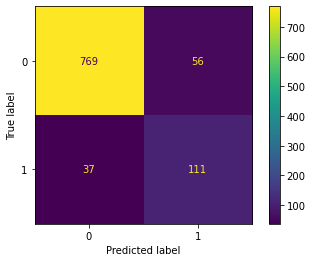

In [25]:
y_pred= [1 if i>=0.5 else 0 for i in y_proba]
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

plt.show()

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       825
           1       0.66      0.75      0.70       148

    accuracy                           0.90       973
   macro avg       0.81      0.84      0.82       973
weighted avg       0.91      0.90      0.91       973



In [27]:
num_map = {i:f for i,f in zip(range(cat_feats_end, cat_feats_end+len(numeric_feats)), numeric_feats)}
def var_map(x):
    if x <= 51:
        ret='Var1_cat{}'.format(x)
    elif (x > 51) and (x <= 54):
        ret='Var5_cat{}'.format(x)
    elif (x > 54) and (x <= 57):
        ret='Var6_cat{}'.format(x)
    else: ret=num_map[x]
    return ret

In [28]:
feature_names = [var_map(i) for i in range(X_test.shape[1])]

In [29]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test.toarray())

### Below we see the plot of feature variables sorted by importance
- We see that features `Var8`, `Var20` and `Var11` ended up to be the top 3 important features for the model, this aligns with what we saw from EDA above that for these variables positive and negative samples has some difference in their data distribution
- All categorical variables considered as important features (`Var1_cat*`, `Var5_cat*`, `Var6_cat*`)

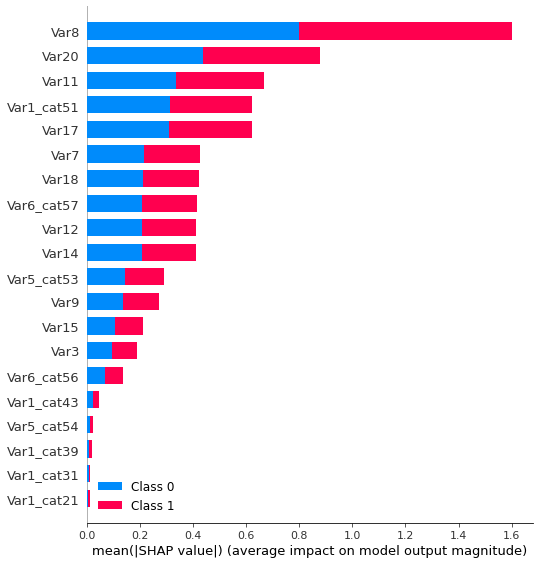

In [30]:
shap.summary_plot(shap_values, X_test.toarray(), feature_names=feature_names)

#### Use the trained model to predict `dataset_test_1.csv`, transform target variable same as above

In [31]:
holdout_data = pd.read_csv('DataChallenge/dataset_test_1.csv', index_col=0)
holdout_data = reformat_data(holdout_data)
holdout_data.head(2)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Target
0,C2,71.0,415.0,0731015efe10b09a50d71bb517c18920,no,no,0.0,211.2,70.0,35.90,...,122.0,21.48,225.8,104.0,10.16,12.3,3.0,3.32,0.0,0
1,K2,76.0,415.0,c5b00e27b93854e0f6d68c886756a56a,no,no,0.0,204.0,NaN,34.68,...,110.0,19.13,240.3,85.0,10.81,9.6,5.0,2.59,1.0,0


#### Use data pipeline defined above to transform the holdout dataset, then predict outcomes

In [32]:
holdout_proba = bst.predict(data_pipeline.transform(holdout_data), num_iteration=bst.best_iteration)

#### LightGBM `predict` outputs probability of `Target = 1`, I've binarized this by considering `probability >= 0.5` as `Target = 1`, otherwise `Target = 0`

In [33]:
holdout_pred= [1 if i>=0.5 else 0 for i in holdout_proba]

In [34]:
holdout_true=holdout_data['Target']

In [35]:
holdout_true.value_counts()

0    288
1     47
Name: Target, dtype: int64

#### Result:

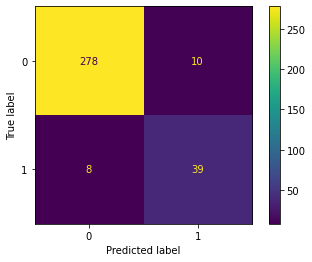

In [36]:
cm = confusion_matrix(holdout_true, holdout_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()

plt.show()

In [37]:
auc = roc_auc_score(holdout_true, holdout_proba)
print("ROC-AUC: {}".format(roc_auc))

ROC-AUC: 0.8666912366912367
